# Generate Spitzer mosaics from raw pipeline files

1) Query the Spitzer SHA archive around the target position, e.g., 
https://sha.ipac.caltech.edu/applications/Spitzer/SHA/#id=SearchByPosition&RequestClass=ServerRequest&DoSearch=true&SearchByPosition.field.radius=0.13888889000000001&UserTargetWorldPt=316.52057;-58.74497;EQ_J2000&SimpleTargetPanel.field.resolvedBy=nedthensimbad&MoreOptions.field.prodtype=aor,pbcd,bcd&shortDesc=Position&isBookmarkAble=true&isDrillDownRoot=true&isSearchResult=true
2) Download "Level 1 Products, Including Ancillary".  
3) Download reddest filter mosaic from, e.g., 
https://s3.amazonaws.com/grizli-v1/Pipeline/j210604m5845/Prep/j210604m5845.summary.html

In [75]:
%matplotlib inline

In [76]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

from skimage.morphology import binary_dilation

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import astropy.units as u

import drizzlepac
from drizzlepac.astrodrizzle import ablot

from grizli import utils

# Need to move these to public repo
from research.grizli import irac 
from research.grizli.process_irac import get_wcslist

In [77]:
# My HST / CHArGE naming convention
root='j210604m5845'

root = 'j142632p3508'

root = 'j025708m2326'

PATH = '/Users/gbrammer/Research/HST/CHArGE/IRAC/'+root
try:
    os.mkdir(PATH)
except:
    pass
os.chdir(PATH)

In [78]:
# Download files 
for ext in ['_phot.fits', '-f160w_drz_sci.fits.gz', '-f160w_drz_wht.fits.gz', 
            '-f160w_psf.fits', '-ir_drz_sci.fits.gz', '-ir_drz_wht.fits.gz', '-ir_seg.fits.gz']:
    file=root+ext
    if len(glob.glob(file.strip('.gz')+'*')) == 0:
        print(file)
        os.system(f'wget -O {file} https://s3.amazonaws.com/grizli-v1/Pipeline/{root}/Prep/{file}')

# Gunzip
os.system('gunzip *fits.gz')

# Copy of the catalog for IRAC photometry
if not os.path.exists(f'{root}_irac_phot.fits'):
    os.system(f'cp {root}_phot.fits {root}_irac_phot.fits')

j025708m2326_phot.fits
j025708m2326-f160w_drz_sci.fits.gz
j025708m2326-f160w_drz_wht.fits.gz
j025708m2326-f160w_psf.fits
j025708m2326-ir_drz_sci.fits.gz
j025708m2326-ir_drz_wht.fits.gz
j025708m2326-ir_seg.fits.gz


In [79]:
# Generate SHA URL
phot = utils.read_catalog(f'{root}_phot.fits')
ra, dec = np.median(phot['ra']), np.median(phot['dec'])

radius = 10. # arcmin

URL = "https://sha.ipac.caltech.edu/applications/Spitzer/SHA/#id=SearchByPosition&"
URL += f"RequestClass=ServerRequest&DoSearch=true&SearchByPosition.field.radius={radius/60:.5f}"
URL += f"&UserTargetWorldPt={ra};{dec};EQ_J2000&SimpleTargetPanel.field.resolvedBy=nedthensimbad&"
URL += "MoreOptions.field.prodtype=aor,pbcd,bcd&shortDesc=Position&isBookmarkAble=true&isDrillDownRoot=true&"
URL += "isSearchResult=true"

print(URL)

https://sha.ipac.caltech.edu/applications/Spitzer/SHA/#id=SearchByPosition&RequestClass=ServerRequest&DoSearch=true&SearchByPosition.field.radius=0.16667&UserTargetWorldPt=44.291228987900595;-23.438403688972944;EQ_J2000&SimpleTargetPanel.field.resolvedBy=nedthensimbad&MoreOptions.field.prodtype=aor,pbcd,bcd&shortDesc=Position&isBookmarkAble=true&isDrillDownRoot=true&isSearchResult=true


In [81]:
# Unzip the SHA zip files
files = glob.glob('tgt*zip')
files.sort()

for file in files:
    print(file)
    os.system(f'unzip -n {file}')

tgt-728-selected_BCDs-part2.zip
tgt-728-selected_BCDs-part3.zip
tgt-728-selected_BCDs-part4.zip
tgt-728-selected_BCDs.zip


In [82]:
# Drizzle properties of the preliminary mosaic
pixfrac, pix, kernel = 0.2, 1.0, 'square'

In [83]:
# Define an output WCS aligned in pixel phase to the HST mosaic ()

if not os.path.exists('ref_hdu.fits'):
    wcslist = get_wcslist(skip=10)
    out_hdu = utils.make_maximal_wcs(wcslist, pixel_scale=pix, theta=0, pad=5, get_hdu=True, verbose=True)
    
    # Make sure pixels align
    ref_file = glob.glob('{0}-f1*_drz_sci.fits'.format(root))[-1]
    
    print(f'\nHST reference image: {ref_file}\n')
    
    ref_hdu = pyfits.open(ref_file)[0].header
    ref_filter = utils.get_hst_filter(ref_hdu).lower()
    
    ref_wcs = pywcs.WCS(ref_hdu)
    ref_rd = ref_wcs.all_pix2world(np.array([[-0.5, -0.5]]), 0).flatten()
    target_phase = np.array([0.5, 0.5])#/(pix/0.1)
    for k in ['RADESYS', 'LATPOLE', 'LONPOLE']:
        out_hdu.header[k] = ref_hdu[k]
        
    # Shift CRVAL to same tangent point
    out_wcs = pywcs.WCS(out_hdu.header)
    out_xy = out_wcs.all_world2pix(np.array([ref_wcs.wcs.crval]), 1).flatten()
    out_hdu.header['CRVAL1'], out_hdu.header['CRVAL2'] = tuple(ref_wcs.wcs.crval)
    out_hdu.header['CRPIX1'], out_hdu.header['CRPIX2'] = tuple(out_xy)
    
    # Align integer pixel phase
    out_wcs = pywcs.WCS(out_hdu.header)
    out_xy = out_wcs.all_world2pix(np.array([ref_rd]), 0).flatten()
    xy_phase = out_xy - np.floor(out_xy)
    new_crpix = out_wcs.wcs.crpix - (xy_phase - target_phase)
    out_hdu.header['CRPIX1'], out_hdu.header['CRPIX2'] = tuple(new_crpix)
    out_wcs = pywcs.WCS(out_hdu.header)
    
    out_hdu.writeto('ref_hdu.fits', output_verify='Fix')
    
else:
    out_hdu = pyfits.open('ref_hdu.fits')[1]


1 72
2 72
3 72
4 72
5 72
6 72
7 72
8 72
9 72
10 72
11 72
12 72
13 72
14 72
15 72
16 72
17 72
18 72
19 72
20 72
21 72
22 72
23 72
24 72
25 72
26 72
27 72
28 72
29 72
30 72
31 72
32 72
33 72
34 72
35 72
36 72
37 72
38 72
39 72
40 72
41 72
42 72
43 72
44 72
45 72
46 72
47 72
48 72
49 72
50 72
51 72
52 72
53 72
54 72
55 72
56 72
57 72
58 72
59 72
60 72
61 72
62 72
63 72
64 72
65 72
66 72
67 72
68 72
69 72
70 72
71 72
72 72
73 72
  0/ 73: WCS[SCI,0]   27.08
  1/ 73: WCS[SCI,0]   33.90
  2/ 73: WCS[SCI,0]   36.24
  3/ 73: WCS[SCI,0]   39.62
  4/ 73: WCS[SCI,0]   39.67
  5/ 73: WCS[SCI,0]   39.71
  6/ 73: WCS[SCI,0]   39.90
  7/ 73: WCS[SCI,0]   40.59
  8/ 73: WCS[SCI,0]   42.67
  9/ 73: WCS[SCI,0]   43.99
 10/ 73: WCS[SCI,0]   71.07
 11/ 73: WCS[SCI,0]   76.34
 12/ 73: WCS[SCI,0]   81.37
 13/ 73: WCS[SCI,0]   81.64
 14/ 73: WCS[SCI,0]   84.70
 15/ 73: WCS[SCI,0]   88.79
 16/ 73: WCS[SCI,0]   91.38
 17/ 73: WCS[SCI,0]   94.04
 18/ 73: WCS[SCI,0]   94.07
 19/ 73: WCS[SCI,0]   94.07
 20/ 73: WC

## Set up by Spitzer "channel" (filter, instrument)

Probably you'll just want channels 1 and 2, but the scripts should work for all IRAC channels and MIPS 24 um.

In [84]:
min_frametime = 20

query = 'r*'
files = glob.glob('{0}/ch*/bcd/SPITZER_I*cbcd.fits'.format(query))
files += glob.glob('{0}/ch*/bcd/SPITZER_I*xbcd.fits.gz'.format(query))
files += glob.glob('{0}/ch*/bcd/SPITZER_M*ebcd.fits'.format(query))
files.sort()

roots = np.array([file.split('/')[0] for file in files])
channels = np.array([file.split('_')[1] for file in files])
all_roots = np.array(['{0}-{1}'.format(r, c.replace('I','ch').replace('M', 'mips')) for r, c in zip(roots, channels)])

tab = {'aor':[], 'N':[], 'channel':[]}
for r in np.unique(all_roots):
    tab['aor'].append(r.split('-')[0])
    tab['N'].append((all_roots == r).sum())
    tab['channel'].append(r.split('-')[1])

aors = utils.GTable(tab)
print(aors)

   aor     N  channel
--------- --- -------
r37857024 182     ch1
r37857024 182     ch2
r37857280 182     ch1
r37857280 182     ch2


In [85]:
SKIP = True          # Don't regenerate finished files
delete_group = False # Delete intermediate products from memory
zip_outputs = False    # GZip intermediate products

channels = ['ch1','ch2','ch3','ch4','mips1']
aors_ch = {}

## Reprocess the mosaics by AOR

This loop pretty much does everything to make the final mosaics and generates empirical PSFs based on GAIA stars.

In [86]:
# Process in groups, helps for fields like HFF with dozens/hundreds of AORs!
for ch in channels:
    
    aor = aors[(aors['channel'] == ch) & (aors['N'] > 5)]
    if len(aor) == 0:
        continue
    
    #aors_ch[ch] = []
        
    if ch in ['ch1','ch2']:
        NPER, instrument, min_frametime = 500, 'irac', 10
    if ch in ['ch3','ch4']:
        NPER, instrument, min_frametime = 500, 'irac', 10
        #NPER, instrument, min_frametime = 800, 'irac', 20
    elif ch in ['mips1']:
        NPER, instrument, min_frametime, pix = 400, 'mips', 2, 1.0

    nsort = np.cumsum(aor['N']/NPER)
    NGROUP = int(np.ceil(nsort.max()))

    count = 0

    for g in range(NGROUP):
        root_i = root+'-{0:02d}'.format(g)
    
        gsel = (nsort > g) & (nsort <= g+1)
        aor_ids = list(aor['aor'][gsel])
        print('{0}-{1}   N_AOR = {2:>2d}  N_EXP = {3:>4d}'.format(root_i, ch,  len(aor_ids), aor['N'][gsel].sum()))
        count += gsel.sum()
    
        files = glob.glob('{0}-{1}*'.format(root_i, ch))
        if (len(files) > 0) & (SKIP): 
            print('Skip {0}-{1}'.format(root_i, ch))
            continue

        # Do internal alignment to GAIA.  
        # Otherwise, set `radec` to the name of a file that has two columns with 
        # reference ra/dec.
        radec = None 

        # Pipeline
        if instrument == 'mips':
            aors_ch[ch] = irac.process_all(channel=ch.replace('mips','ch'), output_root=root_i, 
                                           driz_scale=pix, kernel=kernel, pixfrac=pixfrac, wcslist=None, 
                                           pad=0, out_hdu=out_hdu, aor_ids=aor_ids, flat_background=False, 
                                           two_pass=True, min_frametime=min_frametime, instrument=instrument, 
                                           align_threshold=0.15, radec=radec, run_alignment=False, 
                                           mips_ext='_ebcd.fits')
        else:
            aors_ch[ch] = irac.process_all(channel=ch, output_root=root_i, 
                                           driz_scale=pix, kernel=kernel, pixfrac=pixfrac, wcslist=None, 
                                           pad=0, out_hdu=out_hdu, aor_ids=aor_ids, flat_background=False, 
                                           two_pass=True, min_frametime=min_frametime, instrument=instrument, 
                                           radec=radec)
    
        if len(aors_ch[ch]) == 0:
            continue
            
        # PSFs
        plt.ioff()
        
        if instrument != 'mips':
            psf_size=20
            ch_num = int(ch[-1])
            segmask=True
            for p in [0.1, pix]:
                irac.mosaic_psf(output_root=root_i, target_pix=p, channel=ch_num, aors=aors_ch[ch], 
                                kernel=kernel, pixfrac=pixfrac, size=psf_size, native_orientation=False, 
                                instrument=instrument, subtract_background=False, segmentation_mask=segmask, 
                                max_R=10)
                plt.close('all')
    
            psf_size=30
            p = 0.1
            irac.mosaic_psf(output_root=root_i, target_pix=p, channel=ch_num, aors=aors_ch[ch], 
                            kernel=kernel, pixfrac=pixfrac, size=psf_size, native_orientation=True, 
                            subtract_background=False, segmentation_mask=segmask, max_R=10)
                        
            plt.close('all')
            
        if delete_group:
            del(aors_ch[ch])
        
        print('Done {0}-{1}, gzip products'.format(root_i, ch))
        
        if zip_outputs:
            os.system('gzip {0}*-{1}_drz*fits'.format(root_i, ch))
    
    if instrument != 'mips':
        # Average PSF
        p = 0.1
        files = glob.glob('*{0}-{1:.1f}*psfr.fits'.format(ch, p))
        files.sort()
        avg = None
        for file in files: 
            im = pyfits.open(file)
            if avg is None:
                wht = im[0].data != 0
                avg = im[0].data*wht
            else:
                wht_i = im[0].data != 0
                avg += im[0].data*wht_i
                wht += wht_i

        avg = avg/wht
        avg[wht == 0] = 0
    
        # Window
        from photutils import (HanningWindow, TukeyWindow, CosineBellWindow,
                               SplitCosineBellWindow, TopHatWindow)

        coswindow = CosineBellWindow(alpha=1)
        avg *= coswindow(avg.shape)**0.05
        avg /= avg.sum()
    
        pyfits.writeto('{0}-{1}-{2:0.1f}.psfr_avg.fits'.format(root, ch, p), data=avg, 
                       header=im[0].header, overwrite=True)

j025708m2326-00-ch1   N_AOR =  2  N_EXP =  364

#####
1/2: r37857024 182
#####

err_scale: 0.70
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate tran

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
make_SEP_catalog: sep version = 1.10.0
sep: Image AB zeropoint =  23.900
SEP: Get background {'bh': 8.000000000000238, 'bw': 8.000000000000238, 'fh': 3, 'fw': 3}
SEP: err_scale=1.000
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.10.0
compute_SEP_auto_params: autoparams=[2.5, 3.5]; pixel_scale=0.9999999999999704; subpix=5; flux_radii=[0.2, 0.5, 0.9]
# SEP r37857024-ch1.cat.fits: 1465 objects
SELECT TOP 100000 * FROM gaiadr2.gaia_source  WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),C

95 r37857024/ch1/bcd/SPITZER_I1_37857024_0096_0000_5_cbcd.fits
96 r37857024/ch1/bcd/SPITZER_I1_37857024_0097_0000_5_cbcd.fits
97 r37857024/ch1/bcd/SPITZER_I1_37857024_0098_0000_5_cbcd.fits
98 r37857024/ch1/bcd/SPITZER_I1_37857024_0099_0000_5_cbcd.fits
99 r37857024/ch1/bcd/SPITZER_I1_37857024_0100_0000_5_cbcd.fits
100 r37857024/ch1/bcd/SPITZER_I1_37857024_0101_0000_5_cbcd.fits
101 r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_cbcd.fits
102 r37857024/ch1/bcd/SPITZER_I1_37857024_0103_0000_5_cbcd.fits
103 r37857024/ch1/bcd/SPITZER_I1_37857024_0104_0000_5_cbcd.fits
104 r37857024/ch1/bcd/SPITZER_I1_37857024_0105_0000_5_cbcd.fits
105 r37857024/ch1/bcd/SPITZER_I1_37857024_0106_0000_5_cbcd.fits
106 r37857024/ch1/bcd/SPITZER_I1_37857024_0107_0000_5_cbcd.fits
107 r37857024/ch1/bcd/SPITZER_I1_37857024_0108_0000_5_cbcd.fits
108 r37857024/ch1/bcd/SPITZER_I1_37857024_0109_0000_5_cbcd.fits
109 r37857024/ch1/bcd/SPITZER_I1_37857024_0110_0000_5_cbcd.fits
110 r37857024/ch1/bcd/SPITZER_I1_37857024_011

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinat

7 r37857280/ch1/bcd/SPITZER_I1_37857280_0008_0000_1_cbcd.fits
8 r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_cbcd.fits
9 r37857280/ch1/bcd/SPITZER_I1_37857280_0010_0000_1_cbcd.fits
10 r37857280/ch1/bcd/SPITZER_I1_37857280_0011_0000_1_cbcd.fits
11 r37857280/ch1/bcd/SPITZER_I1_37857280_0012_0000_1_cbcd.fits
12 r37857280/ch1/bcd/SPITZER_I1_37857280_0013_0000_1_cbcd.fits
13 r37857280/ch1/bcd/SPITZER_I1_37857280_0014_0000_1_cbcd.fits
14 r37857280/ch1/bcd/SPITZER_I1_37857280_0015_0000_1_cbcd.fits
15 r37857280/ch1/bcd/SPITZER_I1_37857280_0016_0000_1_cbcd.fits
16 r37857280/ch1/bcd/SPITZER_I1_37857280_0017_0000_1_cbcd.fits
17 r37857280/ch1/bcd/SPITZER_I1_37857280_0018_0000_1_cbcd.fits
18 r37857280/ch1/bcd/SPITZER_I1_37857280_0019_0000_1_cbcd.fits
19 r37857280/ch1/bcd/SPITZER_I1_37857280_0020_0000_1_cbcd.fits
20 r37857280/ch1/bcd/SPITZER_I1_37857280_0021_0000_1_cbcd.fits
21 r37857280/ch1/bcd/SPITZER_I1_37857280_0022_0000_1_cbcd.fits
22 r37857280/ch1/bcd/SPITZER_I1_37857280_0023_0000_1_cbcd.

138 r37857280/ch1/bcd/SPITZER_I1_37857280_0139_0000_1_cbcd.fits
139 r37857280/ch1/bcd/SPITZER_I1_37857280_0140_0000_1_cbcd.fits
140 r37857280/ch1/bcd/SPITZER_I1_37857280_0141_0000_1_cbcd.fits
141 r37857280/ch1/bcd/SPITZER_I1_37857280_0142_0000_1_cbcd.fits
142 r37857280/ch1/bcd/SPITZER_I1_37857280_0143_0000_1_cbcd.fits
143 r37857280/ch1/bcd/SPITZER_I1_37857280_0144_0000_1_cbcd.fits
144 r37857280/ch1/bcd/SPITZER_I1_37857280_0145_0000_1_cbcd.fits
145 r37857280/ch1/bcd/SPITZER_I1_37857280_0146_0000_1_cbcd.fits
146 r37857280/ch1/bcd/SPITZER_I1_37857280_0147_0000_1_cbcd.fits
147 r37857280/ch1/bcd/SPITZER_I1_37857280_0148_0000_1_cbcd.fits
148 r37857280/ch1/bcd/SPITZER_I1_37857280_0149_0000_1_cbcd.fits
149 r37857280/ch1/bcd/SPITZER_I1_37857280_0150_0000_1_cbcd.fits
150 r37857280/ch1/bcd/SPITZER_I1_37857280_0151_0000_1_cbcd.fits
151 r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_cbcd.fits
152 r37857280/ch1/bcd/SPITZER_I1_37857280_0153_0000_1_cbcd.fits
153 r37857280/ch1/bcd/SPITZER_I1_3785728

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinat

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinat

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinat

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinat

r37857024/ch1/bcd/SPITZER_I1_37857024_0047_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0048_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0049_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0050_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0051_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0052_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0053_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0054_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0055_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0056_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0057_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0059_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0060_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0061_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0062_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0063_0000_5_wcs.fi

r37857280/ch1/bcd/SPITZER_I1_37857280_0017_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0018_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0019_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0020_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0021_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0022_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0023_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0025_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0026_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0027_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0028_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0029_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0030_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0031_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0032_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0033_0000_1_wcs.fi

r37857280/ch1/bcd/SPITZER_I1_37857280_0169_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0170_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0171_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0172_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0173_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0174_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0175_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0176_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0177_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0178_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0179_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0180_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_wcs.fits
r37857280-ch1_med.fits
make_SEP_catalog: sep version = 1.10.0
sep: Image AB zeropoint =  23.900
SEP: Get background {'bh': 8.000000000000082, 'bw': 8.000000000000082, 'fh': 3, 'fw': 3}
SEP: err_scale=1.003
   SEP: Extract...
    Done

14 44.27837862972898 -23.332813943594843 18.54818652870762 204 211.8053
15 44.262307691704116 -23.30734527415212 15.886824331586407 66 215.68182
16 44.19018461962089 -23.30541488632893 26.923308580671346 44 154.92363
17 44.1652015545754 -23.295855470000475 17.854217872796195 54 17.251247
18 44.22743162210599 -23.28487219661119 15.676346541801255 204 123.38878
make_SEP_catalog: sep version = 1.10.0
sep: Image AB zeropoint =  23.900
SEP: Get background {'bh': 8.000000000000082, 'bw': 8.000000000000082, 'fh': 3, 'fw': 3}
SEP: err_scale=1.003
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.10.0
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>]; pixel_scale=0.9999999999999899; subpix=5; flux_radii=[0.2, 0.5, 0.9]
# SEP j025708m2326-00-ch1.cat.fits: 2200 objects
No overlap
0 44.3207553193236 -23.6071605510386 49.5433672298664 0 1.5644095
1 44.34902032389626 -23.587643498696973 47.48231649674708 14938 2.8614004
2 44.38770110487969 -23.5873415565965 249.71

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinat

16 r37857024/ch2/bcd/SPITZER_I2_37857024_0017_0000_5_cbcd.fits
17 r37857024/ch2/bcd/SPITZER_I2_37857024_0018_0000_5_cbcd.fits
18 r37857024/ch2/bcd/SPITZER_I2_37857024_0019_0000_5_cbcd.fits
19 r37857024/ch2/bcd/SPITZER_I2_37857024_0020_0000_5_cbcd.fits
20 r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_cbcd.fits
21 r37857024/ch2/bcd/SPITZER_I2_37857024_0022_0000_5_cbcd.fits
22 r37857024/ch2/bcd/SPITZER_I2_37857024_0023_0000_5_cbcd.fits
23 r37857024/ch2/bcd/SPITZER_I2_37857024_0024_0000_5_cbcd.fits
24 r37857024/ch2/bcd/SPITZER_I2_37857024_0025_0000_5_cbcd.fits
25 r37857024/ch2/bcd/SPITZER_I2_37857024_0026_0000_5_cbcd.fits
26 r37857024/ch2/bcd/SPITZER_I2_37857024_0027_0000_5_cbcd.fits
27 r37857024/ch2/bcd/SPITZER_I2_37857024_0028_0000_5_cbcd.fits
28 r37857024/ch2/bcd/SPITZER_I2_37857024_0029_0000_5_cbcd.fits
29 r37857024/ch2/bcd/SPITZER_I2_37857024_0030_0000_5_cbcd.fits
30 r37857024/ch2/bcd/SPITZER_I2_37857024_0031_0000_5_cbcd.fits
31 r37857024/ch2/bcd/SPITZER_I2_37857024_0032_0000_5_cb

147 r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_cbcd.fits
148 r37857024/ch2/bcd/SPITZER_I2_37857024_0149_0000_5_cbcd.fits
149 r37857024/ch2/bcd/SPITZER_I2_37857024_0150_0000_5_cbcd.fits
150 r37857024/ch2/bcd/SPITZER_I2_37857024_0151_0000_5_cbcd.fits
151 r37857024/ch2/bcd/SPITZER_I2_37857024_0152_0000_5_cbcd.fits
152 r37857024/ch2/bcd/SPITZER_I2_37857024_0153_0000_5_cbcd.fits
153 r37857024/ch2/bcd/SPITZER_I2_37857024_0154_0000_5_cbcd.fits
154 r37857024/ch2/bcd/SPITZER_I2_37857024_0155_0000_5_cbcd.fits
155 r37857024/ch2/bcd/SPITZER_I2_37857024_0156_0000_5_cbcd.fits
156 r37857024/ch2/bcd/SPITZER_I2_37857024_0157_0000_5_cbcd.fits
157 r37857024/ch2/bcd/SPITZER_I2_37857024_0158_0000_5_cbcd.fits
158 r37857024/ch2/bcd/SPITZER_I2_37857024_0159_0000_5_cbcd.fits
159 r37857024/ch2/bcd/SPITZER_I2_37857024_0160_0000_5_cbcd.fits
160 r37857024/ch2/bcd/SPITZER_I2_37857024_0161_0000_5_cbcd.fits
161 r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_cbcd.fits
162 r37857024/ch2/bcd/SPITZER_I2_3785702

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinat

57 r37857280/ch2/bcd/SPITZER_I2_37857280_0058_0000_1_cbcd.fits
58 r37857280/ch2/bcd/SPITZER_I2_37857280_0059_0000_1_cbcd.fits
59 r37857280/ch2/bcd/SPITZER_I2_37857280_0060_0000_1_cbcd.fits
60 r37857280/ch2/bcd/SPITZER_I2_37857280_0061_0000_1_cbcd.fits
61 r37857280/ch2/bcd/SPITZER_I2_37857280_0062_0000_1_cbcd.fits
62 r37857280/ch2/bcd/SPITZER_I2_37857280_0063_0000_1_cbcd.fits
63 r37857280/ch2/bcd/SPITZER_I2_37857280_0064_0000_1_cbcd.fits
64 r37857280/ch2/bcd/SPITZER_I2_37857280_0065_0000_1_cbcd.fits
65 r37857280/ch2/bcd/SPITZER_I2_37857280_0066_0000_1_cbcd.fits
66 r37857280/ch2/bcd/SPITZER_I2_37857280_0067_0000_1_cbcd.fits
67 r37857280/ch2/bcd/SPITZER_I2_37857280_0068_0000_1_cbcd.fits
68 r37857280/ch2/bcd/SPITZER_I2_37857280_0069_0000_1_cbcd.fits
69 r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_cbcd.fits
70 r37857280/ch2/bcd/SPITZER_I2_37857280_0071_0000_1_cbcd.fits
71 r37857280/ch2/bcd/SPITZER_I2_37857280_0072_0000_1_cbcd.fits
72 r37857280/ch2/bcd/SPITZER_I2_37857280_0073_0000_1_cb

# SEP j025708m2326-00-ch2.cat.fits: 2597 objects

 0 r37857024 

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-b


 1 r37857280 

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
0 r37857024 181
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C

Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
1 r37857280 181
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C

r37857024/ch2/bcd/SPITZER_I2_37857024_0001_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0002_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0003_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0004_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0005_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0006_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0008_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0009_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0010_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0011_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0012_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0013_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0014_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0015_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0016_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0017_0000_5_wcs.fi

r37857024/ch2/bcd/SPITZER_I2_37857024_0150_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0151_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0152_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0153_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0154_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0155_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0156_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0157_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0158_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0159_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0160_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0161_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0163_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0164_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0165_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0166_0000_5_wcs.fi

r37857280/ch2/bcd/SPITZER_I2_37857280_0111_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0113_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0114_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0115_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0116_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0117_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0118_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0119_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0120_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0121_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0122_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0123_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0124_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0125_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0126_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_wcs.fi

3 44.32821535117626 -23.464742910240208 18.813888963466756 221 114.20192
4 44.21350385560302 -23.430033747400493 9.708071993017876 66 19.83282
5 44.30635163847889 -23.40485387602491 13.740025647409682 79 160.51694
6 44.31917761350005 -23.402419530828098 14.79964426845846 32 126.19154
7 44.33923317062139 -23.40536758504443 83.67498841422645 157 32.8922
8 44.230713145520085 -23.37445239896836 69.24872514322864 92 116.97005
9 44.28318689846582 -23.365702664095377 14.019244857888875 47 95.72962
10 44.32603113609555 -23.349670211203517 59.959443181227314 59 12.18302
11 44.2631236894971 -23.344953664306903 150.8368358541664 0 192.26158
12 44.27837981161389 -23.332814327445906 11.498279744602964 193 182.20183
13 44.312782493816854 -23.331799381295294 120.39502777249255 9 21.53171
14 44.18069928663043 -23.31640051365148 29.554253337676876 41 48.947815
15 44.26231014823084 -23.307347675510663 13.573627481819 67 183.99739
16 44.19018569153786 -23.305413589955574 20.807890121808303 0 86.55932
0 4

j025708m2326-00-ch1_drz_sci.fits CH1 33716.8 s
j025708m2326-00-ch2_drz_sci.fits CH2 34868.8 s


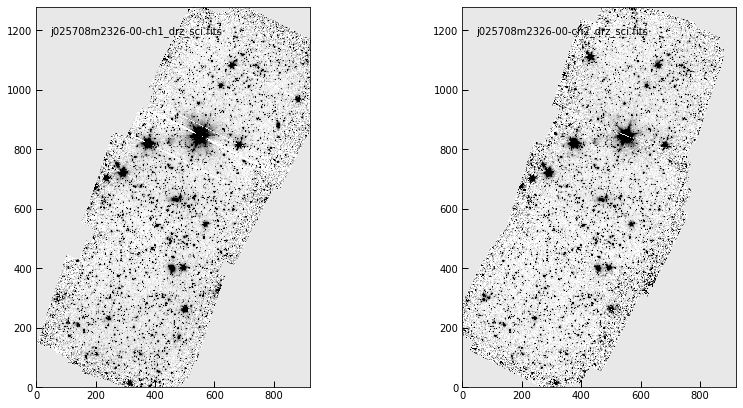

In [87]:
## Show the product
files = glob.glob(f'{root}-00-ch*sci.fits')
files.sort()

fig = plt.figure(figsize=[14, 7])
for i, file in enumerate(files[:2]):
    im = pyfits.open(file)
    print('{0} {1} {2:.1f} s'.format(file, im[0].header['FILTER'], im[0].header['EXPTIME']))
    ax = fig.add_subplot(1,2,1+i)
    ax.imshow(im[0].data, vmin=-0.1, vmax=1, cmap='gray_r')
    ax.text(0.05, 0.95, file, ha='left', va='top', color='k', 
            transform=ax.transAxes)
    
if 0:
    # Zoom in
    x0, y0, N = 600, 600, 50
    for ax in fig.axes:
        ax.set_xlim(x0-N, x0+N)
        ax.set_ylim(y0-N, y0+N)

In [88]:
# Make more compact individual exposures and clean directories
wfiles = glob.glob('r*/*/bcd/*_I[1-4]_*wcs.fits')
#wfiles = glob.glob('r*/*/bcd/*_M[1-4]_*wcs.fits')
wfiles.sort()
for wcsfile in wfiles:
    outfile = wcsfile.replace('_wcs.fits', '_xbcd.fits.gz')
    if os.path.exists(outfile):
        print(outfile)
    else:
        irac.combine_products(wcsfile)
        print('Run: ', outfile)
    
    if os.path.exists(outfile):
        remove_files = glob.glob('{0}*fits'.format(wcsfile.split('_wcs')[0]))
        for f in remove_files:
            print('   rm ', f)
            os.remove(f)

r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_bimsk.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0002_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0002_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0002_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0002_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0002_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0002_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0002_0000_5_bunc.fit

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0016_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0016_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0016_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0016_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0016_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0016_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0016_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0016_0000_5_cbunc.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0017_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0017_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0017_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0017_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0017_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0017_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0017_0000_5_brmsk

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0030_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0030_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0030_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0030_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0030_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0030_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0030_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0030_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0031_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0031_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0031_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0031_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0031_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0031_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0031_0000_5_bi

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0044_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0044_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0044_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0044_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0044_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0044_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0044_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0044_0000_5_bcd.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0045_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0045_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0045_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0045_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0045_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0045_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0045_0000_5_brms

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0058_0000_5_cbcd.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0059_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0059_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0059_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0059_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0059_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0059_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0059_0000_5_brmsk

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_brmsk.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0073_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0073_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0073_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0073_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0073_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0073_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0073_0000_5_cbunc

r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0087_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0088_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0088_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0088_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0088_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0088_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0088_0000_5_brmsk.f

r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0102_0000_5_wcs.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0103_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0103_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0103_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0103_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0103_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0103_0000_5_brmsk.f

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0117_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0117_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0117_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0117_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0117_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0117_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0117_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0117_0000_5_cbunc.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0118_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0118_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0118_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0118_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0118_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0118_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0118_0000_5_bunc.

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0131_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0131_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0131_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0131_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0131_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0131_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0131_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0131_0000_5_bcd.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0132_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0132_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0132_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0132_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0132_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0132_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0132_0000_5_brms

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_bunc.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0146_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0146_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0146_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0146_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0146_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0146_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0146_0000_5_cbcd.

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0159_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0159_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0159_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0159_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0159_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0159_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0159_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0159_0000_5_cbunc.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0160_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0160_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0160_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0160_0000_5_brmsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0160_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0160_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0160_0000_5_bcd

Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0173_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0173_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0173_0000_5_bunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0173_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0173_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0173_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0173_0000_5_cbunc.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0173_0000_5_brmsk.fits
r37857024/ch1/bcd/SPITZER_I1_37857024_0174_0000_5_xbcd.fits.gz
Run:  r37857024/ch1/bcd/SPITZER_I1_37857024_0174_0000_5_xbcd.fits.gz
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0174_0000_5_bcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0174_0000_5_bimsk.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0174_0000_5_wcs.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0174_0000_5_cbcd.fits
   rm  r37857024/ch1/bcd/SPITZER_I1_37857024_0174_0000_5_brmsk

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0007_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0008_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0008_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0008_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0008_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0008_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0008_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0008_0000_5_brms

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0021_0000_5_cbunc.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0022_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0022_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0022_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0022_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0022_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0022_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0022_0000_5_cbun

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0035_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0035_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0035_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0035_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0035_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0035_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0035_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0035_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0036_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0036_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0036_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0036_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0036_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0036_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0036_0000_5_cbun

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0049_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0049_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0049_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0049_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0049_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0049_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0049_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0049_0000_5_bcd.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0050_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0050_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0050_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0050_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0050_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0050_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0050_0000_5_bim

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0063_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0063_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0063_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0063_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0063_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0063_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0063_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0063_0000_5_wcs.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0064_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0064_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0064_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0064_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0064_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0064_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0064_0000_5_bim

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0077_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0077_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0077_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0077_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0077_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0077_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0077_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0077_0000_5_cbunc.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0078_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0078_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0078_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0078_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0078_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0078_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0078_0000_5_cbun

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0091_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0091_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0091_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0091_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0091_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0091_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0091_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0091_0000_5_brmsk.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0092_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0092_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0092_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0092_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0092_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0092_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0092_0000_5_cbu

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0105_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0105_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0105_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0105_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0105_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0105_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0105_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0105_0000_5_bimsk.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0106_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0106_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0106_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0106_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0106_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0106_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0106_0000_5_cb

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0119_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0119_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0119_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0119_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0119_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0119_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0119_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0119_0000_5_bimsk.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0120_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0120_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0120_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0120_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0120_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0120_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0120_0000_5_cbcd.

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0133_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0133_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0133_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0133_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0133_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0133_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0133_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0133_0000_5_bcd.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0134_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0134_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0134_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0134_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0134_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0134_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0134_0000_5_wc

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0148_0000_5_cbcd.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0149_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0149_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0149_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0149_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0149_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0149_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0149_0000_5_bim

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0162_0000_5_bcd.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0163_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0163_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0163_0000_5_cbunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0163_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0163_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0163_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0163_0000_5_bun

Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0176_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0176_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0176_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0176_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0176_0000_5_brmsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0176_0000_5_bunc.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0176_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0176_0000_5_cbunc.fits
r37857024/ch2/bcd/SPITZER_I2_37857024_0177_0000_5_xbcd.fits.gz
Run:  r37857024/ch2/bcd/SPITZER_I2_37857024_0177_0000_5_xbcd.fits.gz
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0177_0000_5_wcs.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0177_0000_5_bimsk.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0177_0000_5_bcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0177_0000_5_cbcd.fits
   rm  r37857024/ch2/bcd/SPITZER_I2_37857024_0177_0000_5_brmsk

   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0008_0000_1_cbcd.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0009_0000_1_bcd.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0010_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0010_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0010_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0010_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0010_0000_1_bunc.fi

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0024_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0025_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0025_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0025_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0025_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0025_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0025_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0025_0000_1_wc

r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0038_0000_1_bunc.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0039_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0039_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0039_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0039_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0039_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0039_0000_1_cbunc.fit

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0053_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0053_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0053_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0053_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0053_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0053_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0053_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0053_0000_1_cbcd.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0054_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0054_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0054_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0054_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0054_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0054_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0054_0000_1_bcd.

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0067_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0067_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0067_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0067_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0067_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0067_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0067_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0067_0000_1_bunc.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0068_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0068_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0068_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0068_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0068_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0068_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0068_0000_1_cbcd

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0081_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0081_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0081_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0081_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0081_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0081_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0081_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0081_0000_1_bunc.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0082_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0082_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0082_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0082_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0082_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0082_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0082_0000_1_bc

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0095_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0095_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0095_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0095_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0095_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0095_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0095_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0095_0000_1_bunc.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0096_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0096_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0096_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0096_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0096_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0096_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0096_0000_1_cbcd.

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0109_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0109_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0109_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0109_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0109_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0109_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0109_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0109_0000_1_bcd.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0110_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0110_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0110_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0110_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0110_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0110_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0110_0000_1_bu

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0123_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0123_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0123_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0123_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0123_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0123_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0123_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0123_0000_1_wcs.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0124_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0124_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0124_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0124_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0124_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0124_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0124_0000_1_cb

r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0138_0000_1_bimsk.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0139_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0139_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0139_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0139_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0139_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0139_0000_1_wcs.fits

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0152_0000_1_brmsk.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0153_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0153_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0153_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0153_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0153_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0153_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0153_0000_1_bcd.

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_brmsk.fits
r37857280/ch1/bcd/SPITZER_I1_37857280_0168_0000_1_xbcd.fits.gz
Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0168_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0168_0000_1_cbunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0168_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0168_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0168_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0168_0000_1_brmsk

Run:  r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_xbcd.fits.gz
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_bimsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_bunc.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_bcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_cbcd.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_wcs.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_brmsk.fits
   rm  r37857280/ch1/bcd/SPITZER_I1_37857280_0181_0000_1_cbunc.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0001_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0001_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0001_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0001_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0001_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0001_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0001_0000_1_cbunc

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_cbcd.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0015_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0015_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0015_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0015_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0015_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0015_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0015_0000_1_bun

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0028_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0028_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0028_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0028_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0028_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0028_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0028_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0028_0000_1_bcd.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0029_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0029_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0029_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0029_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0029_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0029_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0029_0000_1_brms

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0042_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0042_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0042_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0042_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0042_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0042_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0042_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0042_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0043_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0043_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0043_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0043_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0043_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0043_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0043_0000_1_wc

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0056_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0056_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0056_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0056_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0056_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0056_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0056_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0056_0000_1_cbunc.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0057_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0057_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0057_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0057_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0057_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0057_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0057_0000_1_bunc.

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0070_0000_1_wcs.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0071_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0071_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0071_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0071_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0071_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0071_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0071_0000_1_bim

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_brmsk.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0085_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0085_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0085_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0085_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0085_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0085_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0085_0000_1_bcd.

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0098_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0098_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0098_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0098_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0098_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0098_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0098_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0098_0000_1_bcd.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0099_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0099_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0099_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0099_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0099_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0099_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0099_0000_1_wcs

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0112_0000_1_bcd.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0113_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0113_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0113_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0113_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0113_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0113_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0113_0000_1_bu

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0127_0000_1_bunc.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0128_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0128_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0128_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0128_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0128_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0128_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0128_0000_1_bcd

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0141_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0141_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0141_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0141_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0141_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0141_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0141_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0141_0000_1_bimsk.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0142_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0142_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0142_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0142_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0142_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0142_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0142_0000_1_wcs

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_bcd.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0156_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0156_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0156_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0156_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0156_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0156_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0156_0000_1_cbcd

Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0169_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0169_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0169_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0169_0000_1_bimsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0169_0000_1_bcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0169_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0169_0000_1_wcs.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0169_0000_1_cbcd.fits
r37857280/ch2/bcd/SPITZER_I2_37857280_0170_0000_1_xbcd.fits.gz
Run:  r37857280/ch2/bcd/SPITZER_I2_37857280_0170_0000_1_xbcd.fits.gz
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0170_0000_1_bunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0170_0000_1_brmsk.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0170_0000_1_cbunc.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0170_0000_1_cbcd.fits
   rm  r37857280/ch2/bcd/SPITZER_I2_37857280_0170_0000_1_bi

# Drizzle final mosaics

Here this doesn't do much, but if you had many AORs you want to recombine all of the images into a final mosaic with new drizzle parameters.

In [89]:
# Make final mosaic a bit bigger than the HST image
pad = 1.1

# Pixel scale of final mosaic.
# Don't make too small if not many dithers available as in this example.
# But for well-sampled mosaics like RELICS / HFF, can push this to perhaps 0.3" / pix
pixscale = 0.5

# Again, if have many dithers maybe can use more aggressive drizzle parameters,
# like a 'point' kernel or smaller pixfrac (a 'point' kernel is pixfrac=0)
kernel, pixfrac = 'square', 0.2

# Correction for bad columns near bright stars
pulldown_mag = 16.2 

##############
# Dilation for CR rejection
dil = np.ones((3,3))
driz_cr = [7, 4]
blot_interp = 'poly5'
bright_fmax = 0.5

In [90]:
for ch in ['ch1', 'ch2', 'ch3', 'ch4'][:2]:
    ###########
    # Files and reference image for extra CR rejection
    if ch == 'mips1':
        files = glob.glob('r*/ch1/bcd/SPITZER_M1_*xbcd.fits*'.format(ch))
        files.sort()
        pulldown_mag = -10
    else:
        files = glob.glob('r*/{0}/bcd/*_I?_*xbcd.fits*'.format(ch))
        files.sort()

    ref = pyfits.open('{0}-00-{1}_drz_sci.fits'.format(root, ch))

    ref_wcs = pywcs.WCS(ref[0].header, relax=True) 
    ref_wcs.pscale = utils.get_wcs_pscale(ref_wcs) 
    ref_data = ref[0].data.astype(np.float32)

    ##############
    # Output WCS based on HST footprint
    hst_im = pyfits.open('{0}-f160w_drz_sci.fits'.format(root))
    hst_wcs = pywcs.WCS(hst_im[0])
    hst_wcs.pscale = utils.get_wcs_pscale(hst_wcs) 

    size = (np.round(np.array([hst_wcs._naxis1, hst_wcs._naxis2])*hst_wcs.pscale*pad/pixscale)*pixscale)

    out_header, out_wcs = utils.make_wcsheader(ra=hst_wcs.wcs.crval[0], 
                                               dec=hst_wcs.wcs.crval[1], size=size, 
                                               pixscale=pixscale, get_hdu=False, theta=0)

    ##############
    # Bright stars for pulldown correction
    ph = utils.read_catalog('{0}-00-{1}.cat.fits'.format(root, ch)) 
    bright = (ph['mag_auto'] < pulldown_mag) # & (ph['flux_radius'] < 3)
    ph = ph[bright]

    ##############
    # Now do the drizzling
    yp, xp = np.indices((256, 256))
    orig_files = []

    out_header['DRIZ_CR0'] = driz_cr[0]
    out_header['DRIZ_CR1'] = driz_cr[1]
    out_header['KERNEL'] = kernel
    out_header['PIXFRAC'] = pixfrac
    out_header['NDRIZIM'] = 0
    out_header['EXPTIME'] = 0
    out_header['BUNIT'] = 'microJy'
    out_header['FILTER'] = ch
    
    med_root = 'xxx'
    N = len(files)

    for i, file in enumerate(files):#[:100]):

        print('{0}/{1} {2}'.format(i, N, file))

        if file in orig_files:
            continue

        im = pyfits.open(file)
        ivar = 1/im['CBUNC'].data**2    
        msk = (~np.isfinite(ivar)) | (~np.isfinite(im['CBCD'].data))
        im['CBCD'].data[msk] = 0
        ivar[msk] = 0

        wcs = pywcs.WCS(im['WCS'].header, relax=True)
        wcs.pscale = utils.get_wcs_pscale(wcs)
        fp = Path(wcs.calc_footprint())

        med_root_i = im.filename().split('/')[0]
        if med_root != med_root_i:
            print('\n Read {0}-{1}_med.fits \n'.format(med_root_i, ch))
            med = pyfits.open('{0}-{1}_med.fits'.format(med_root_i, ch))
            med_data = med[0].data.astype(np.float32)
            med_root = med_root_i

            try:
                gaia_rd = utils.read_catalog('{0}-{1}_gaia.radec'.format(med_root_i, ch))
                ii, rr = gaia_rd.match_to_catalog_sky(ph)
                gaia_rd = gaia_rd[ii][rr.value < 2]
                gaia_pts = np.array([gaia_rd['ra'].data, gaia_rd['dec'].data]).T
            except:
                gaia_rd = []

        #data = im['CBCD'].data - aor_med[0].data

        # Change output units to uJy / pix
        if ch == 'mips1':
            # un = 1*u.MJy/u.sr
            # #to_ujy_px = un.to(u.uJy/u.arcsec**2).value*(out_wcs.pscale**2)
            # to_ujy_px = un.to(u.uJy/u.arcsec**2).value*(native_scale**2)
            to_ujy_px = 146.902690
        else:
            to_ujy_px = 35.17517196810

        blot_data = ablot.do_blot(ref_data, ref_wcs, wcs, 1, coeffs=True, interp=blot_interp, 
                                  sinscl=1.0, stepsize=10, wcsmap=None)/to_ujy_px

        # mask for bright stars
        eblot = 1-np.clip(blot_data, 0, bright_fmax)/bright_fmax

        # Initial CR
        clean = im[0].data - med[0].data - im['WCS'].header['PEDESTAL']
        dq = (clean - blot_data)*np.sqrt(ivar)*eblot > driz_cr[0]

        # Adjacent CRs
        dq_dil = binary_dilation(dq, selem=dil)
        dq |= ((clean - blot_data)*np.sqrt(ivar)*eblot > driz_cr[1]) & (dq_dil)

        # Very negative pixels
        dq |= clean*np.sqrt(ivar) < -4

        original_dq = im['WCS'].data - (im['WCS'].data & 1)
        dq |= original_dq > 0

        # Pulldown correction for bright stars
        if len(gaia_rd) > 0:       
            mat = fp.contains_points(gaia_pts) 
            if mat.sum() > 0:
                xg, yg = wcs.all_world2pix(gaia_rd['ra'][mat], gaia_rd['dec'][mat], 0)
                sh = dq.shape
                mat = (xg > 0) & (xg < sh[1]) & (yg > 0) & (yg < sh[0])
                if mat.sum() > 0:
                    for xi, yi in zip(xg[mat], yg[mat]):
                        dq |= (np.abs(xp-xi) < 2) & (np.abs(yp-yi) > 10)

        if i == 0:
            res = utils.drizzle_array_groups([clean], [ivar*(dq == 0)], [wcs], outputwcs=out_wcs, 
                                             kernel=kernel, pixfrac=pixfrac, data=None)
            # Copy header keywords
            wcs_header = utils.to_header(wcs)
            for k in im[0].header:
                if (k not in ['', 'HISTORY', 'COMMENT']) & (k not in out_header) & (k not in wcs_header):
                    out_header[k] = im[0].header[k]
                
        else:
            _ = utils.drizzle_array_groups([clean], [ivar*(dq == 0)], [wcs], outputwcs=out_wcs, 
                                           kernel=kernel, pixfrac=pixfrac, data=res[:3])

        out_header['NDRIZIM'] += 1
        out_header['EXPTIME'] += im[0].header['EXPTIME']

    # Pixel scale factor for weights
    wht_scale = (out_wcs.pscale/wcs.pscale)**-4

    # Write final images
    pyfits.writeto('{0}-{1}_drz_sci.fits'.format(root, ch), data=res[0]*to_ujy_px, header=out_header, 
                   output_verify='fix', overwrite=True)
    pyfits.writeto('{0}-{1}_drz_wht.fits'.format(root, ch), data=res[1]*wht_scale/to_ujy_px**2, 
                   header=out_header, output_verify='fix', overwrite=True)

0/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0001_0000_5_xbcd.fits.gz

 Read r37857024-ch1_med.fits 

Using default C-based coordinate transformation...
1/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0002_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
2/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0003_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
3/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0004_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
4/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0005_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
5/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0006_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
6/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0007_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
7/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0008_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
8/362 r3

Using default C-based coordinate transformation...
70/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0071_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
71/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0072_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
72/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0073_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
73/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0074_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
74/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0075_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
75/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0076_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
76/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0077_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
77/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0078_0000_5_xbcd.fits.gz
Using default C-based coordinate

137/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0138_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
138/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0139_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
139/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0140_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
140/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0141_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
141/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0142_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
142/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0143_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
143/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0144_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
144/362 r37857024/ch1/bcd/SPITZER_I1_37857024_0145_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
145/362 r37857024/ch1/bc

209/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0029_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
210/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0030_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
211/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0031_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
212/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0032_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
213/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0033_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
214/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0034_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
215/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0035_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
216/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0036_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
217/362 r37857280/ch1/bc

Using default C-based coordinate transformation...
279/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0099_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
280/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0100_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
281/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0101_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
282/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0102_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
283/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0103_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
284/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0104_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
285/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0105_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
286/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0106_0000_1_xbcd.fits.gz
Using default C-based co

346/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0166_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
347/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0167_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
348/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0168_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
349/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0169_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
350/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0170_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
351/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0171_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
352/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0172_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
353/362 r37857280/ch1/bcd/SPITZER_I1_37857280_0173_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
354/362 r37857280/ch1/bc

Using default C-based coordinate transformation...
52/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0053_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
53/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0054_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
54/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0055_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
55/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0056_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
56/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0057_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
57/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0058_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
58/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0059_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
59/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0060_0000_5_xbcd.fits.gz
Using default C-based coordinate

Using default C-based coordinate transformation...
123/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0124_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
124/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0125_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
125/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0126_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
126/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0127_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
127/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0128_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
128/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0129_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
129/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0130_0000_5_xbcd.fits.gz
Using default C-based coordinate transformation...
130/362 r37857024/ch2/bcd/SPITZER_I2_37857024_0131_0000_5_xbcd.fits.gz
Using default C-based co

Using default C-based coordinate transformation...
191/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0011_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
192/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0012_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
193/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0013_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
194/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0014_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
195/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0015_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
196/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0016_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
197/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0017_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
198/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0018_0000_1_xbcd.fits.gz
Using default C-based co

261/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0081_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
262/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0082_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
263/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0083_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
264/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0084_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
265/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0085_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
266/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0086_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
267/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0087_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
268/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0088_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
269/362 r37857280/ch2/bc

Using default C-based coordinate transformation...
334/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0154_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
335/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0155_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
336/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0156_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
337/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0157_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
338/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0158_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
339/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0159_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
340/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0160_0000_1_xbcd.fits.gz
Using default C-based coordinate transformation...
341/362 r37857280/ch2/bcd/SPITZER_I2_37857280_0161_0000_1_xbcd.fits.gz
Using default C-based co

j025708m2326-ch1_drz_sci.fits ch1 33716.8 s
j025708m2326-ch2_drz_sci.fits ch2 34868.8 s


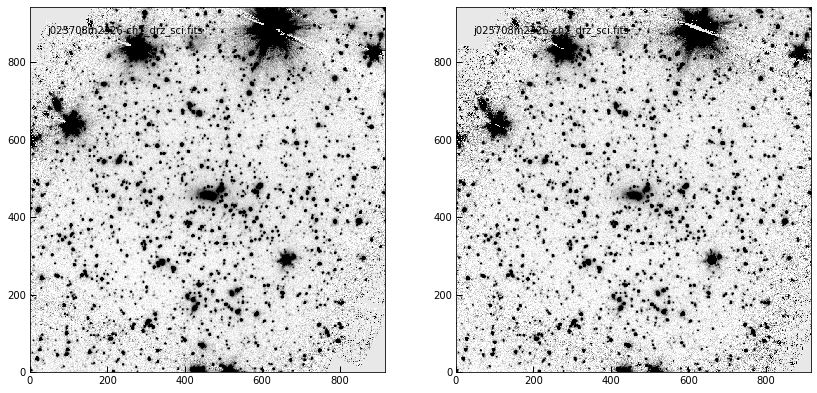

In [91]:
## Show the final products
files = glob.glob(f'{root}-ch*sci.fits')
files.sort()

fig = plt.figure(figsize=[14, 7])
for i, file in enumerate(files[:2]):
    im = pyfits.open(file)
    print('{0} {1} {2:.1f} s'.format(file, im[0].header['FILTER'], im[0].header['EXPTIME']))
    ax = fig.add_subplot(1,2,1+i)
    ax.imshow(im[0].data, vmin=-0.1/4, vmax=1/4, cmap='gray_r')
    ax.text(0.05, 0.95, file, ha='left', va='top', color='k', 
            transform=ax.transAxes)
    
if 0:
    # Zoom in, about the same position
    x0, y0, N = 800, 880, 100
    for ax in fig.axes:
        ax.set_xlim(x0-N, x0+N)
        ax.set_ylim(y0-N, y0+N)

In [47]:
# The pulldown correction was a little overzealous.  

# Check the output mosaics in detail to verify
# that pixscale / pixfrac not too small.